# Geely Auto Case Study

#### Problem Statement
A Chinese automobile company Geely Auto aspires to enter the US market by setting up their manufacturing unit there and producing cars locally to give competition to their US and European counterparts. 

 
They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the American market, since those may be very different from the Chinese market. The company wants to know:

- Which variables are significant in predicting the price of a car
- How well those variables describe the price of a car
Based on various market surveys, the consulting firm has gathered a large dataset of different types of cars across the Americal market. 

#### Business Goal 

You are required to model the price of cars with the available independent variables. It will be used by the management to understand how exactly the prices vary with the independent variables. They can accordingly manipulate the design of the cars, the business strategy etc. to meet certain price levels. Further, the model will be a good way for management to understand the pricing dynamics of a new market. 

The steps we will follow in this are as follows:

1. Reading, understanding and visualising the data
2. Preparing the data for modelling (train-test split, rescaling etc.)
3. Trainnig the model
4. Residual analysis
5. Predictions and evaluation on test set

Let us first import numpy and pandas

In [1637]:
# Importing basic packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import matplotlib.pyplot as plt
import seaborn as sns

In [1638]:
# Supressing warnings
import warnings
warnings.filterwarnings('ignore')

Importing packages for linear regression

In [1639]:
# module for performing test train split
from sklearn.model_selection import train_test_split
# Module for feture scaling
from sklearn.preprocessing import MinMaxScaler
# statmodel linear regression
import statsmodels.api as sm
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### Custom Methods

Let's define all custom methods here for code conciseness.

### Custom Function Definations for Plotting and Visualization

In [1640]:
def pairplot(data):
    plt.figure(figsize = (20, 26))
    sns.pairplot(data)
    plt.show()
    
def plotHeatMap(dataSet):
    plt.figure(figsize = (20, 26))
    plt.subplot(2, 1, 1)
    sns.heatmap(dataSet.corr(), cmap="YlGnBu", annot = True)
    plt.show()
    
def boxplot(categorical_vars, dataSet,labelRotation, size, row, column):
    plt.figure(figsize = size)
    plt.xticks(rotation = labelRotation)
    for index, category in enumerate(categorical_vars):
        plt.subplot(row, column, index + 1)
        sns.boxplot(x = category, y = 'price', data = dataSet)
    plt.show()
    
    ## Wonderful solution to show labels in bar plots - copied from https://stackoverflow.com/a/48372659 and edited
def showLabels(ax, d=None):
    plt.margins(0.2, 0.2)
    rects = ax.patches
    i = 0
    locs, labels = plt.xticks() 
    counts = {}
    if not d is None:
        for key, value in d.items():
            counts[str(key)] = value

    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        if d is None:
            label = "{:.1f}%".format(y_value)
        else:
            try:
                label = "{:.1f}%".format(y_value) + "\nof " + str(counts[str(labels[i].get_text())])
            except:
                label = "{:.1f}%".format(y_value)
        
        i = i+1

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.
def plot_percentages(dataframe, var_list, row, column, size, sortbyindex=False):
# Plot the percentage of car's in the US market with respect to different car features
    plt.figure(figsize=size)
    for var in var_list:
        plt.subplot(row, column, var_list.index(var)+1)
        values = (dataframe[var].value_counts(normalize=True)*100)
        if sortbyindex:
                values = values.sort_index()
        ax = values.plot.bar(color=sns.color_palette('deep', 16))
        ax.set_ylabel('% in dataset', fontsize=16)
        ax.set_xlabel(var, fontsize=10)
        showLabels(ax)

### Custom Function Definations For Data cleaning

In [1641]:
def replace_col_value(column, value, replace_with, data_set):
    data_set[column].replace(value, replace_with, inplace=True)

### Linear Regression Function Definations for Modeling

In [1642]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
def getVIF_Details(supported_vars):
    vif = pd.DataFrame()
    vif['Features'] = X_train[supported_vars].columns
    vif['VIF'] = [variance_inflation_factor(X_train[supported_vars].values, i) for i in range(X_train[supported_vars].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif


# Get the linear model summary of the selected variables
# 'supported_vars': takes list/array of column name

def buildModelAndGetSummary(supported_vars):
    # Creating X_test dataframe with RFE selected variables
    X_train_rfe = X_train[supported_vars]
    # Adding a constant variable
    X_train_rfe = sm.add_constant(X_train_rfe)
    # Runnig the linear model
    lm = sm.OLS(y_train, X_train_rfe).fit()
    print(lm.summary())
    return lm


# Get the list of selected list of columns after droping columns
# supported_vars: Series of column names
# drop_vars: columns to drop
def getsupportedVars(supported_vars, drop_vars=[]):
    supported_vars = supported_vars.drop(labels=drop_vars)
    return supported_vars

## Step 1: Reading and Understanding the Data

###  Data loading and cleaning

In [1643]:
# Load data to pandas dataframe
carPrice_url = '/Users/balwant/Documents/Machine_Learning_and_AI/Assignment/Geely-Auto_Case-Study/CarPrice_Assignment.csv'
carPrice_data = pd.read_csv(carPrice_url)


In [1644]:
# Firstly, let's have a look at the dimension of data
carPrice_data.shape

(205, 26)

In [1645]:
# Let's have a look at the first few rows of the Data
carPrice_data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [1646]:
# Let's have a look at all the column names
carPrice_data.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

Some of the important columns in the dataset are 'CarName', 'cylindernumber','enginesize', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'highwaympg' of the carPrice etc.

In [1647]:
# Let's define a method for checking missing value.
def findMissingValueCountPerCols(carPrice):
    number_of_missing_value_per_column = carPrice.isnull().sum()
    return number_of_missing_value_per_column.loc[number_of_missing_value_per_column > 0]

In [1648]:
# Let's check number of missing value per column.
findMissingValueCountPerCols(carPrice_data)

Series([], dtype: int64)

Luckly we have no null values in the dataset

In [1649]:
#Let's reconfirm with alternate way.
carPrice_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

__Awsome!__ No null values found in the dataset

In [1650]:
# Let's check for duplicate values in dataset
sum(carPrice_data.duplicated(subset = 'car_ID')) == 0


True

In [1651]:
# Let's check the statistical summary of dataset
carPrice_data.describe()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


As we already know, There is a variable named CarName which is comprised of two parts - the first word is the name of 'car company' and the second is the 'car model'
You need to consider only company name as the independent variable for model building. 

In [1652]:
#Let have look in CarName unique column values
carPrice_data['CarName'].unique()

array(['alfa-romero giulia', 'alfa-romero stelvio',
       'alfa-romero Quadrifoglio', 'audi 100 ls', 'audi 100ls',
       'audi fox', 'audi 5000', 'audi 4000', 'audi 5000s (diesel)',
       'bmw 320i', 'bmw x1', 'bmw x3', 'bmw z4', 'bmw x4', 'bmw x5',
       'chevrolet impala', 'chevrolet monte carlo', 'chevrolet vega 2300',
       'dodge rampage', 'dodge challenger se', 'dodge d200',
       'dodge monaco (sw)', 'dodge colt hardtop', 'dodge colt (sw)',
       'dodge coronet custom', 'dodge dart custom',
       'dodge coronet custom (sw)', 'honda civic', 'honda civic cvcc',
       'honda accord cvcc', 'honda accord lx', 'honda civic 1500 gl',
       'honda accord', 'honda civic 1300', 'honda prelude',
       'honda civic (auto)', 'isuzu MU-X', 'isuzu D-Max ',
       'isuzu D-Max V-Cross', 'jaguar xj', 'jaguar xf', 'jaguar xk',
       'maxda rx3', 'maxda glc deluxe', 'mazda rx2 coupe', 'mazda rx-4',
       'mazda glc deluxe', 'mazda 626', 'mazda glc', 'mazda rx-7 gs',
       'mazda glc 

In [1653]:
# Extract the company name from the 'CarName' column & create new column 'carCompany' for the same.
carPrice_data['carCompany'] = carPrice_data['CarName'].apply(lambda x: x.split(" ")[0].lower())

In [1654]:
#Let's have a look at 'carCompany' how is look like.
carPrice_data['carCompany'].head()

0    alfa-romero
1    alfa-romero
2    alfa-romero
3           audi
4           audi
Name: carCompany, dtype: object

In [1655]:
# Let's look how many unique car company in dataset.
carPrice_data['carCompany'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

Here, we observe that there are multiple company name being misspelled
- maxda, mazda
- porsche, porcshce
- toyota, toyouta
- vokswagen, volkswagen, vw

In [1656]:
#Lets correct this in the data.
replace_col_value('carCompany', 'maxda', 'mazda', carPrice_data)
replace_col_value('carCompany', 'porsche', 'porcshce', carPrice_data)
replace_col_value('carCompany', 'vokswagen', 'volkswagen', carPrice_data)
replace_col_value('carCompany', 'vw', 'volkswagen', carPrice_data)

In [1657]:
# Let's look after removing misspelled carCompany name.
carPrice_data['carCompany'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porcshce', 'renault', 'saab',
       'subaru', 'toyota', 'toyouta', 'volkswagen', 'volvo'], dtype=object)

Now, It's looking good ,removed misspelled car company name from dataset

In [1658]:
# Let's have a look another categorical variables one by one
# Let's gets all categorical variable list
categorical_var = list(carPrice_data.columns[carPrice_data.dtypes == 'object'])
categorical_var

['CarName',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem',
 'carCompany']

In [1659]:
# Let's look unique fueltype in dataset and correct if required.
carPrice_data['fueltype'].unique()

array(['gas', 'diesel'], dtype=object)

No misspelled value in 'fueltype'.

In [1660]:
# Let's look unique aspiration in dataset and correct if required.
carPrice_data['aspiration'].unique()

array(['std', 'turbo'], dtype=object)

No misspelled value in 'aspiration'.

In [1661]:
# Let's look unique doornumber in dataset and correct if required.
carPrice_data['doornumber'].unique()

array(['two', 'four'], dtype=object)

No misspelled value in 'doornumber'.

In [1662]:
# Let's look unique carbody in dataset and correct if required.
carPrice_data['carbody'].unique()

array(['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop'],
      dtype=object)

No misspelled value in 'doornumber'.

In [1663]:
# Let's look unique drivewheel in dataset and correct if required.
carPrice_data['drivewheel'].unique()

array(['rwd', 'fwd', '4wd'], dtype=object)

Here, we observe that there is'drivewheel' 4wd', 'fwd' being misspelled

In [1664]:
#Lets correct this in the data.
replace_col_value('drivewheel', '4wd', 'fwd', carPrice_data)

In [1665]:
# Let's look after removing misspelled drivewheel name.
carPrice_data['drivewheel'].unique()

array(['rwd', 'fwd'], dtype=object)

No misspelled value in 'drivewheel'.

In [1666]:
# Let's look unique enginelocation in dataset and correct if required.
carPrice_data['enginelocation'].unique()

array(['front', 'rear'], dtype=object)

No misspelled value in 'enginelocation

In [1667]:
# Let's look unique enginetype in dataset and correct if required.
carPrice_data['enginetype'].unique()

array(['dohc', 'ohcv', 'ohc', 'l', 'rotor', 'ohcf', 'dohcv'], dtype=object)

Here, we observe that there is'enginetype' dohcv', 'dohc' being misspelled

In [1668]:
#Lets correct this in the data.
replace_col_value('enginetype', 'dohcv', 'dohc', carPrice_data)

In [1669]:
# Let's look after removing misspelled enginetype name.
carPrice_data['enginetype'].unique()

array(['dohc', 'ohcv', 'ohc', 'l', 'rotor', 'ohcf'], dtype=object)

In [1670]:
# Let's look unique cylindernumber in dataset and correct if required.
carPrice_data['cylindernumber'].unique()

array(['four', 'six', 'five', 'three', 'twelve', 'two', 'eight'],
      dtype=object)

No misspelled value in 'cylindernumber

In [1671]:
# Let's look unique fuelsystem in dataset and correct if required.
carPrice_data['fuelsystem'].unique()

array(['mpfi', '2bbl', 'mfi', '1bbl', 'spfi', '4bbl', 'idi', 'spdi'],
      dtype=object)

Here, we observe that there are multiple enginetype being misspelled

- mfi, mpfi
- spdi, spfi

In [1672]:
#Lets correct this in the data.
replace_col_value('fuelsystem', 'mfi', 'mpfi', carPrice_data)
replace_col_value('fuelsystem', 'spdi', 'spfi', carPrice_data)

In [1673]:
# Let's look after removing misspelled enginetype name.
carPrice_data['fuelsystem'].unique()

array(['mpfi', '2bbl', '1bbl', 'spfi', '4bbl', 'idi'], dtype=object)

Now, It's looking good ,removed misspelled fuelsystem from dataset.



Dropping the 'CarName' & 'Car_ID' column as they are not useful for analysis

In [1674]:

carPrice_data.drop(['CarName', 'car_ID'],axis=1,inplace=True)

Notice there is a high corelation between: 1.carlength, curbweight, wheelbase and carwidth, so we can drop 3 out of 4, so lets drop carwidth and curbweight and wheelbase 2.There is a high corelation of .97 between highwaympg and citympg, so lets drop highwaympg

In [1675]:
carPrice_data.drop(['carwidth','curbweight','wheelbase','highwaympg'], axis =1, inplace = True)

In [1676]:
# Created numerical variable list here for future use.
numerical_var = list(carPrice_data.columns[carPrice_data.dtypes != 'object'])
carPrice_data.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,carlength,carheight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,price,carCompany
0,3,gas,std,two,convertible,rwd,front,168.8,48.8,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,13495.0,alfa-romero
1,3,gas,std,two,convertible,rwd,front,168.8,48.8,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,16500.0,alfa-romero
2,1,gas,std,two,hatchback,rwd,front,171.2,52.4,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,16500.0,alfa-romero
3,2,gas,std,four,sedan,fwd,front,176.6,54.3,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,13950.0,audi
4,2,gas,std,four,sedan,fwd,front,176.6,54.3,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,17450.0,audi


Now that we've read and inspected the data, Let's move on to visualising it. This will help in interpreting the data well and identifying the veriables that can turn out to be usefull in building the model.

###  Data Visualisation

<Figure size 1440x1872 with 0 Axes>

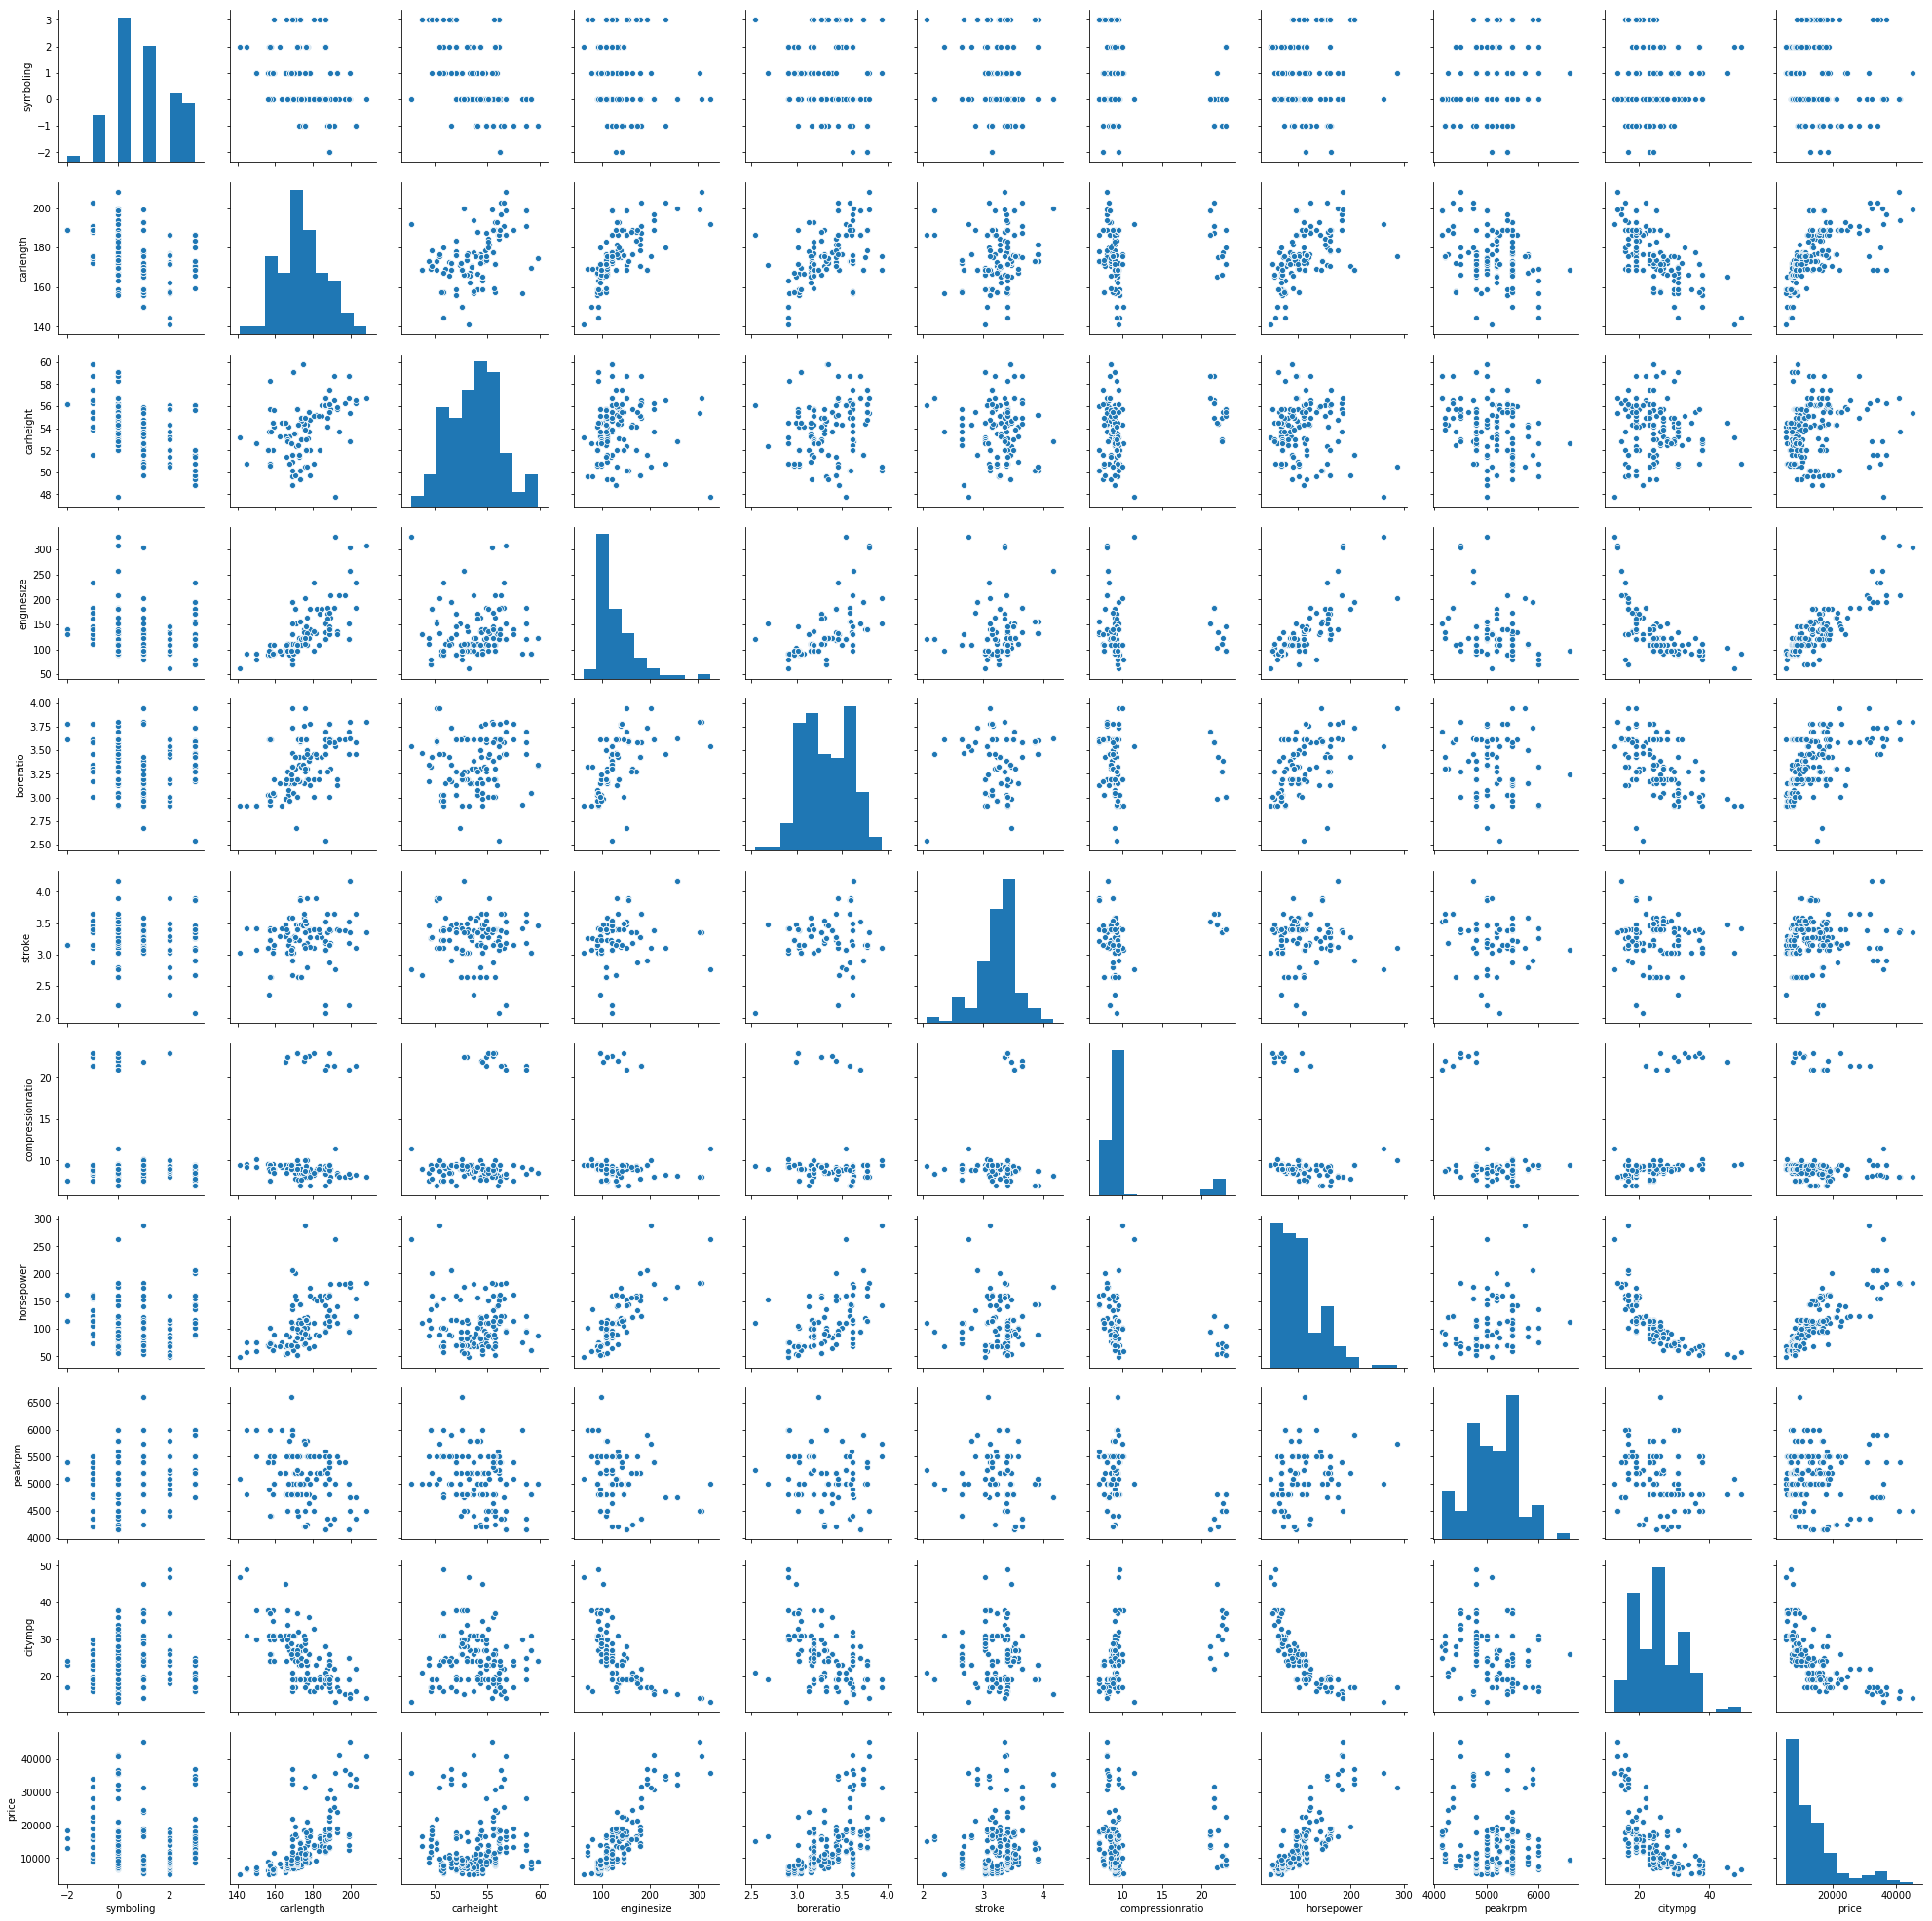

In [1677]:
# Visualising the numeric variables
pairplot(carPrice_data)

That all about visualising the numerical variable. You might have noticed that there are few categorical variables present in the dataset as well. Let's visualiling them too, using boxplot.

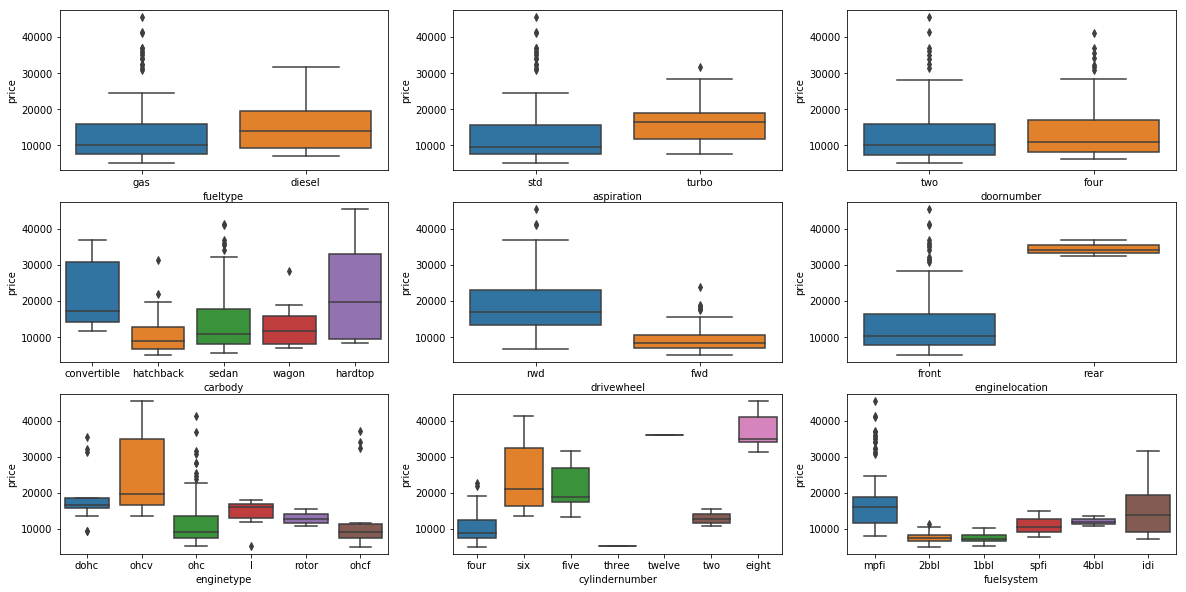

In [1678]:
# Visualising the categorical variables
categorical_var = list(carPrice_data.columns[carPrice_data.dtypes == 'object'])
boxplot(categorical_var[:-1], carPrice_data, 0, (20, 10), 3, 3)

__Observations:__

- Although not significant but still the fuel type seems have an effect on the pricing of the cars. Let's confirm this later.
- enginelocation and aspiration surly has a visible affect on the pricing of the car
- The price of real wheel drive is significantly higher that other drivewheel options.
- cylindernumber and engine type also seem to regulate the price of cars.
- hardtop and convertables cars are definatly priced higher than other body types available. Tells us that variable carbody is contributing in determinig the price.


Let's see how these categorical variables relate one-to-one with the outcome variable price.

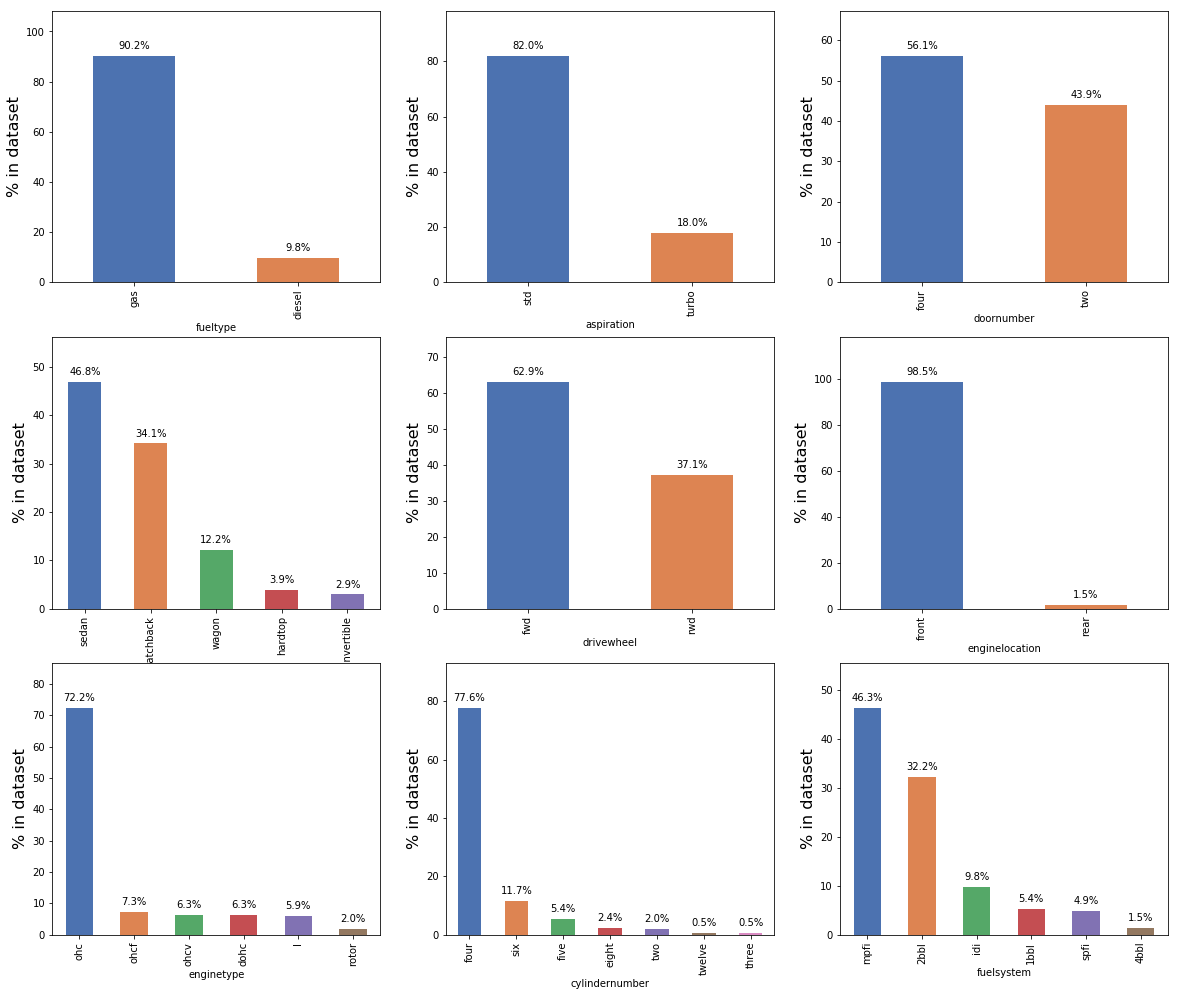

In [1679]:
# Market percentage of car's with respect to features
plot_percentages(carPrice_data,categorical_var[:-1], 3, 3,(20,17))

We can identify the some of the car features that are predominant in the US Automobile Market, Geely Automotives can consider these facts to full fill the market dominant needs and make the needed changes to their manufacturing line. These features are:

- symboling: moderate (0,1)
- Carbody: Sedan
- fueltype: gas
- aspiration: standard
- doornumbers: four
- drivewheel: forward
- engine location: front
- engine type: ohc
- cylinderNumber: four
- fuelSystem: mpfi

Lets see the most popular Automobile company in the US Automobile Market

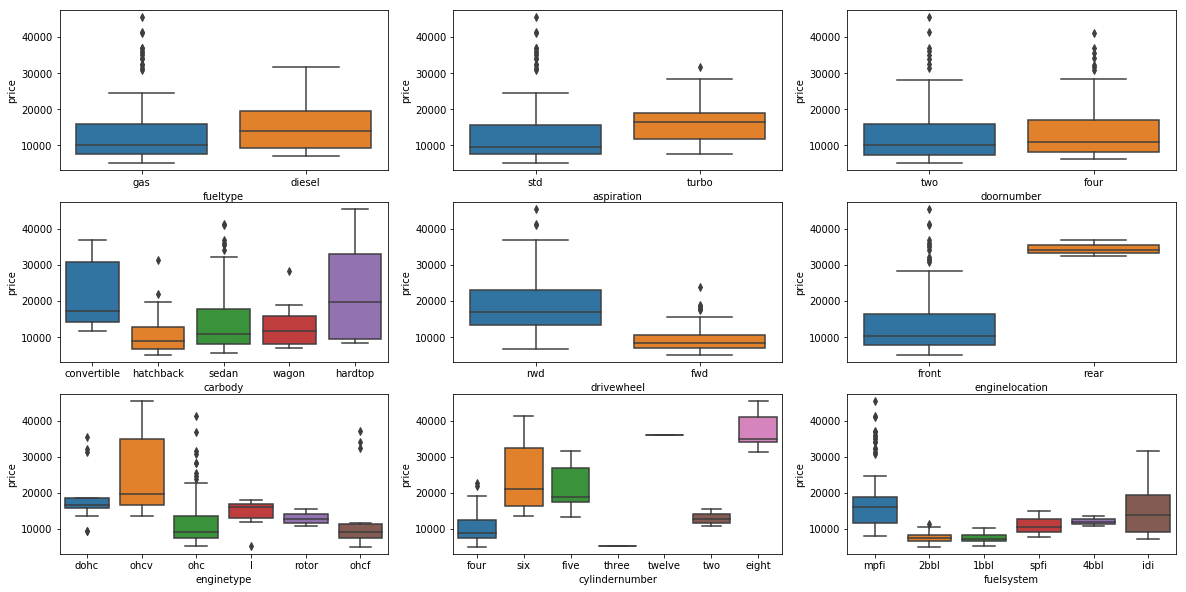

In [1680]:

boxplot(categorical_var[:-1], carPrice_data, 0, (20, 10), 3, 3)

__Observations:__

- Toyota clearly has a dominant market percentage in the US of 15.6%.
- This is followed by:
- Nissan with 8.8%
- Mazda with 8.2%
- Mitsubishi and Honda are equally popular with 6.3% market percentage.

Let's see how the prices vary with the different automobile companies in the US market

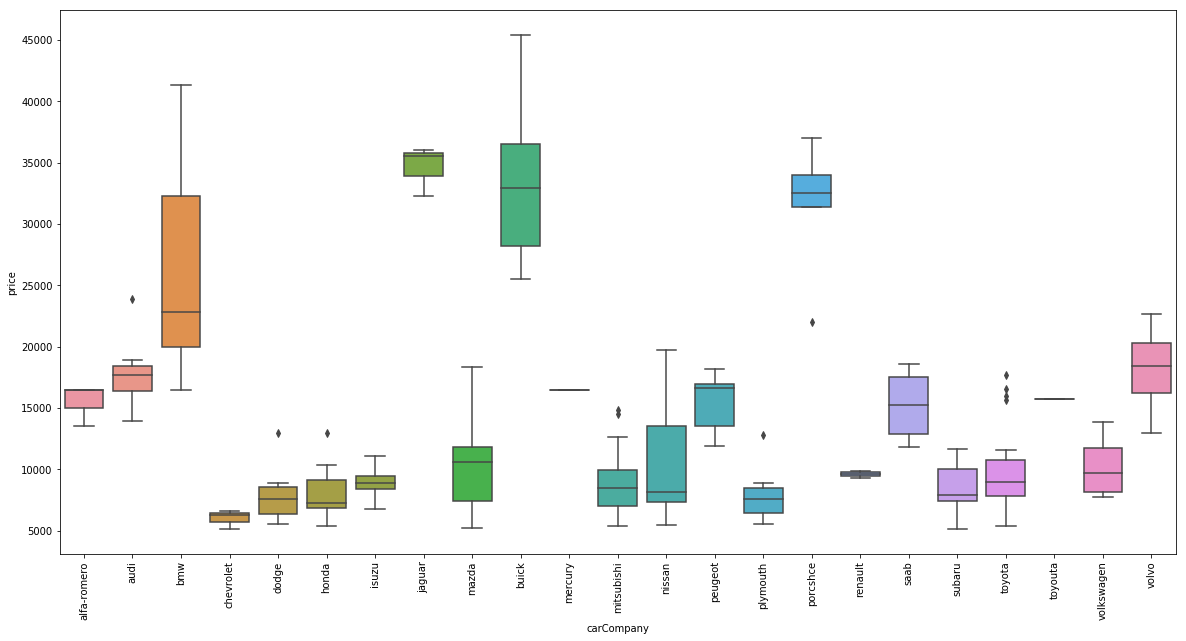

Average US car price:  13276.710570731706
carCompany
jaguar      34600.000000
buick       33647.000000
porcshce    31400.500000
bmw         26118.750000
volvo       18063.181818
Name: price, dtype: float64


In [1681]:
plt.figure(figsize=(20,10))
sns.boxplot(x = categorical_var[-1], y = 'price', data = carPrice_data)
plt.xticks(rotation=90)
plt.show()
print('Average US car price: ',carPrice_data['price'].mean())
print(carPrice_data.groupby('carCompany').price.mean().sort_values(ascending=False).head())

__Observation:__

- Each company has a range in which the cars are priced. There are few outilers for these companies showing that they do manufacture some expensive cars which are priced above their usual market pricing range.
- Cars manufacturers like jaguar, Buick, Porsche, BMW, Volo are clearly on the high end side, priced well above the average US cars price which is approx. $13,000.
- company name shows some affect on the price determination.

In previous sesction we had loaded the dataset and we are made some visualisation to get an intuitive understanding of distribution etc. Let's move on the second step which is preparing the data.

## Step 2: Preparing tha Data for Modelling

Now there are 3-4 steps that we need to do in the data prepare steps
- Encoding
    - Getting Dummy variables of all catergorical values.
- Spliting into train and test
- Rescaling of variables

Note : We will generate dummy for variables which has 2 level instead for assigning binary values for the ease of understanding.

### Dealing with Categorical Fields

In [1682]:
categorical_df = pd.get_dummies(carPrice_data.loc[:,categorical_var], prefix=categorical_var, drop_first=True)
categorical_df.head()

,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_rwd,enginelocation_rear,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spfi,carCompany_audi,carCompany_bmw,carCompany_buick,carCompany_chevrolet,carCompany_dodge,carCompany_honda,carCompany_isuzu,carCompany_jaguar,carCompany_mazda,carCompany_mercury,carCompany_mitsubishi,carCompany_nissan,carCompany_peugeot,carCompany_plymouth,carCompany_porcshce,carCompany_renault,carCompany_saab,carCompany_subaru,carCompany_toyota,carCompany_toyouta,carCompany_volkswagen,carCompany_volvo
0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1683]:
# concat the dummy df with original one
carPrice_data = pd.concat([carPrice_data,categorical_df], axis = 1)
carPrice_data.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,carlength,carheight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,price,carCompany,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_rwd,enginelocation_rear,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spfi,carCompany_audi,carCompany_bmw,carCompany_buick,carCompany_chevrolet,carCompany_dodge,carCompany_honda,carCompany_isuzu,carCompany_jaguar,carCompany_mazda,carCompany_mercury,carCompany_mitsubishi,carCompany_nissan,carCompany_peugeot,carCompany_plymouth,carCompany_porcshce,carCompany_renault,carCompany_saab,carCompany_subaru,carCompany_toyota,carCompany_toyouta,carCompany_volkswagen,carCompany_volvo
0,3,gas,std,two,convertible,rwd,front,168.8,48.8,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,13495.0,alfa-romero,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,gas,std,two,convertible,rwd,front,168.8,48.8,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,16500.0,alfa-romero,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,gas,std,two,hatchback,rwd,front,171.2,52.4,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,16500.0,alfa-romero,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,gas,std,four,sedan,fwd,front,176.6,54.3,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,13950.0,audi,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,gas,std,four,sedan,fwd,front,176.6,54.3,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,17450.0,audi,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now, We can see that, We created dummy variable corresponding to categorical variables, But we still have the original ones which is don't need now. So we need to drop that variable.

In [1684]:
# we can simply do that by bellow method
carPrice_data = carPrice_data.drop(categorical_var, axis = 1)
carPrice_data.head()

,symboling,carlength,carheight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,price,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_rwd,enginelocation_rear,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spfi,carCompany_audi,carCompany_bmw,carCompany_buick,carCompany_chevrolet,carCompany_dodge,carCompany_honda,carCompany_isuzu,carCompany_jaguar,carCompany_mazda,carCompany_mercury,carCompany_mitsubishi,carCompany_nissan,carCompany_peugeot,carCompany_plymouth,carCompany_porcshce,carCompany_renault,carCompany_saab,carCompany_subaru,carCompany_toyota,carCompany_toyouta,carCompany_volkswagen,carCompany_volvo
0,3,168.8,48.8,130,3.47,2.68,9.0,111,5000,21,13495.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,168.8,48.8,130,3.47,2.68,9.0,111,5000,21,16500.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,171.2,52.4,152,2.68,3.47,9.0,154,5000,19,16500.0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,176.6,54.3,109,3.19,3.40,10.0,102,5500,24,13950.0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,176.6,54.3,136,3.19,3.40,8.0,115,5500,18,17450.0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We have completed all the encoding steps which is required before modling

Before model bulding, We need first to perform the __test train split__ and __scale the features__

Scaling of the variables is important, as you have noticed, some of the variables are on diffrent scale with respect to all numerical variables, which take very small values. Also, the categorical veriables that you encoded earlier take either 0's or 1's as their values. Hence, it is important to have everything on the same scale for the model to be easily interpretable.

### Spliting the dataset into train and test

In [1685]:
df_train, df_test = train_test_split(carPrice_data, train_size = 0.7, random_state = 100)
print(df_train.shape, df_test.shape)

(143, 58) (62, 58)


Rescaling the Features
There are two major methods to scale the variables, i.e. standardisation and MinMax scaling. Standardisation basically brings all of the data into a standard normal distribution with mean zero and standard deviation one. MinMax scaling, on the other hand, brings all of the data in the range of 0 and 1. The formulae in the background used for each of these methods are as given below:

Standardisation - (mean-0, sigma- 1)
MinMax Scaling - (Normalisation): compress data between 0 and 1
This time, we will use minMax scaling

In [1686]:
# 1. Instantiate an object
scaler = MinMaxScaler()
# 2. Fit on data
# fit() : learns and compute xmin, xmax
# transform() : compute x-xmin/xmax -xmin
# fit_transform() do both 
df_train[numerical_var] = scaler.fit_transform(df_train[numerical_var])
df_train.head()

,symboling,carlength,carheight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,price,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_rwd,enginelocation_rear,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spfi,carCompany_audi,carCompany_bmw,carCompany_buick,carCompany_chevrolet,carCompany_dodge,carCompany_honda,carCompany_isuzu,carCompany_jaguar,carCompany_mazda,carCompany_mercury,carCompany_mitsubishi,carCompany_nissan,carCompany_peugeot,carCompany_plymouth,carCompany_porcshce,carCompany_renault,carCompany_saab,carCompany_subaru,carCompany_toyota,carCompany_toyouta,carCompany_volkswagen,carCompany_volvo
122,0.6,0.426016,0.265487,0.139623,0.230159,0.525253,0.15000,0.083333,0.551020,0.500000,0.068818,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
125,1.0,0.452033,0.212389,0.339623,1.000000,0.464646,0.15625,0.395833,0.551020,0.166667,0.466890,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
166,0.6,0.448780,0.424779,0.139623,0.444444,0.449495,0.15000,0.266667,1.000000,0.361111,0.122110,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1.0,0.450407,0.088496,0.260377,0.626984,0.247475,0.12500,0.262500,0.346939,0.222222,0.314446,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
199,0.2,0.775610,0.858407,0.260377,0.746032,0.484848,0.03125,0.475000,0.387755,0.111111,0.382131,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Now we see that all categorical variables are remain same and all numeric variable mapped betwwen 0 and 1

In [1687]:
df_train[numerical_var].describe()

,symboling,carlength,carheight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,price
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.559441,0.525476,0.509004,0.241351,0.497946,0.535389,0.190787,0.227302,0.400029,0.344211,0.219310
std,0.239200,0.204848,0.215378,0.154619,0.207140,0.157843,0.237181,0.165511,0.196438,0.186165,0.215682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.399187,0.353982,0.135849,0.305556,0.464646,0.100000,0.091667,0.265306,0.166667,0.067298
50%,0.600000,0.502439,0.522124,0.184906,0.500000,0.545455,0.125000,0.191667,0.428571,0.333333,0.140343
75%,0.600000,0.669919,0.668142,0.301887,0.682540,0.611111,0.150000,0.283333,0.551020,0.500000,0.313479
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's have a look on mean and min, max. so as we can seen here all variables have 1 max value and min 0, MinMaxScaler worked correctlly

## Step- 3: Training the Model

Now that you have prepared the data and are done with the test-train split. Let's divide into X and y sets for the model building.

### Dividing into X and y sets for the model building

In [1688]:
y_train = df_train.pop('price')
X_train = df_train

In [1689]:
# let's have look on few collumn of X_tain
X_train.head()

,symboling,carlength,carheight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_rwd,enginelocation_rear,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spfi,carCompany_audi,carCompany_bmw,carCompany_buick,carCompany_chevrolet,carCompany_dodge,carCompany_honda,carCompany_isuzu,carCompany_jaguar,carCompany_mazda,carCompany_mercury,carCompany_mitsubishi,carCompany_nissan,carCompany_peugeot,carCompany_plymouth,carCompany_porcshce,carCompany_renault,carCompany_saab,carCompany_subaru,carCompany_toyota,carCompany_toyouta,carCompany_volkswagen,carCompany_volvo
122,0.6,0.426016,0.265487,0.139623,0.230159,0.525253,0.15000,0.083333,0.551020,0.500000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
125,1.0,0.452033,0.212389,0.339623,1.000000,0.464646,0.15625,0.395833,0.551020,0.166667,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
166,0.6,0.448780,0.424779,0.139623,0.444444,0.449495,0.15000,0.266667,1.000000,0.361111,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1.0,0.450407,0.088496,0.260377,0.626984,0.247475,0.12500,0.262500,0.346939,0.222222,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
199,0.2,0.775610,0.858407,0.260377,0.746032,0.484848,0.03125,0.475000,0.387755,0.111111,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Building our model
We will be using a mix approach. Initially using the LinearRegression function from SciKit Learn for its compatibility with RFE (which is a utility from sklearn) and then using the Statmodel for statistics analysis of the model

## RFE
Recursive feature elimination

In [1690]:
# Running RFE with the output number of the variable equal to 20
lm = LinearRegression()
lm.fit(X_train, y_train)

# running RFE and selecting 15 features best describing the price of cars
rfe = RFE(lm, 15)             
rfe = rfe.fit(X_train, y_train)

In [1691]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('symboling', False, 31),
 ('carlength', True, 1),
 ('carheight', False, 18),
 ('enginesize', True, 1),
 ('boreratio', True, 1),
 ('stroke', True, 1),
 ('compressionratio', False, 5),
 ('horsepower', True, 1),
 ('peakrpm', False, 14),
 ('citympg', False, 37),
 ('fueltype_gas', False, 24),
 ('aspiration_turbo', False, 16),
 ('doornumber_two', False, 36),
 ('carbody_hardtop', False, 12),
 ('carbody_hatchback', False, 9),
 ('carbody_sedan', False, 11),
 ('carbody_wagon', False, 10),
 ('drivewheel_rwd', False, 38),
 ('enginelocation_rear', False, 34),
 ('enginetype_l', False, 3),
 ('enginetype_ohc', False, 13),
 ('enginetype_ohcf', False, 8),
 ('enginetype_ohcv', False, 40),
 ('enginetype_rotor', True, 1),
 ('cylindernumber_five', True, 1),
 ('cylindernumber_four', True, 1),
 ('cylindernumber_six', False, 32),
 ('cylindernumber_three', True, 1),
 ('cylindernumber_twelve', True, 1),
 ('cylindernumber_two', True, 1),
 ('fuelsystem_2bbl', False, 33),
 ('fuelsystem_4bbl', False, 35),
 ('fuels

In [1692]:
# check FRE selected variables
supported_vars = X_train.columns[rfe.support_]
supported_vars

Index(['carlength', 'enginesize', 'boreratio', 'stroke', 'horsepower',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_three', 'cylindernumber_twelve', 'cylindernumber_two',
       'carCompany_bmw', 'carCompany_buick', 'carCompany_porcshce',
       'carCompany_volvo'],
      dtype='object')

In [1693]:
# check FRE did not selected
X_train.columns[~rfe.support_]

Index(['symboling', 'carheight', 'compressionratio', 'peakrpm', 'citympg',
       'fueltype_gas', 'aspiration_turbo', 'doornumber_two', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_rwd',
       'enginelocation_rear', 'enginetype_l', 'enginetype_ohc',
       'enginetype_ohcf', 'enginetype_ohcv', 'cylindernumber_six',
       'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_idi',
       'fuelsystem_mpfi', 'fuelsystem_spfi', 'carCompany_audi',
       'carCompany_chevrolet', 'carCompany_dodge', 'carCompany_honda',
       'carCompany_isuzu', 'carCompany_jaguar', 'carCompany_mazda',
       'carCompany_mercury', 'carCompany_mitsubishi', 'carCompany_nissan',
       'carCompany_peugeot', 'carCompany_plymouth', 'carCompany_renault',
       'carCompany_saab', 'carCompany_subaru', 'carCompany_toyota',
       'carCompany_toyouta', 'carCompany_volkswagen'],
      dtype='object')

What RFE says, these variables are not usefull

## Building Model using statsmodel, for the detailed statistics

In [1694]:
lr_model = buildModelAndGetSummary(supported_vars)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     120.4
Date:                Sun, 31 May 2020   Prob (F-statistic):           1.76e-66
Time:                        22:49:35   Log-Likelihood:                 206.50
No. Observations:                 143   AIC:                            -383.0
Df Residuals:                     128   BIC:                            -338.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.25

Looking at the p-values, it looks like some of the variables aren't really significant (in the presence of other variables).

__Maybe we could drop some?__

First we look at the significance of variable (p-values), we could be drop some variables, will we drop variable once at time
Now what basis we will drop variable, One we will drop variable once on significance, All another pice of information that we can look at before making the decision which is VIF that let us how a vriable correlated with all other variable.
So we will look at both of these two and than decide whether we will drop the variable or not.

## VIF
Checking the Variance Inflation Factor (VIF) Sometimes pairwise correlations aren't enough Instead of just one variable, the independent variable might depend upon a combination of other variables VIF calculates how well one independent variable is explained by all the other independent variables combined The VIF is given by:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

where 'i' refers to the i-th variable which is being represented as a linear combination of rest of the independent variables. You'll see VIF in action during the Python demonstration on multiple linear regression.


In [1695]:
getVIF_Details(supported_vars)

,Features,VIF
5,enginetype_rotor,inf
10,cylindernumber_two,inf
1,enginesize,81.14
2,boreratio,40.88
3,stroke,36.22
7,cylindernumber_four,26.70
0,carlength,26.47
4,horsepower,14.69
9,cylindernumber_twelve,3.11
6,cylindernumber_five,2.87


As we can see all variable have p-value < 0.05. So we look for correlation using VIF.

Let’s prepare a heat map and take a look at the correlations between the variables.

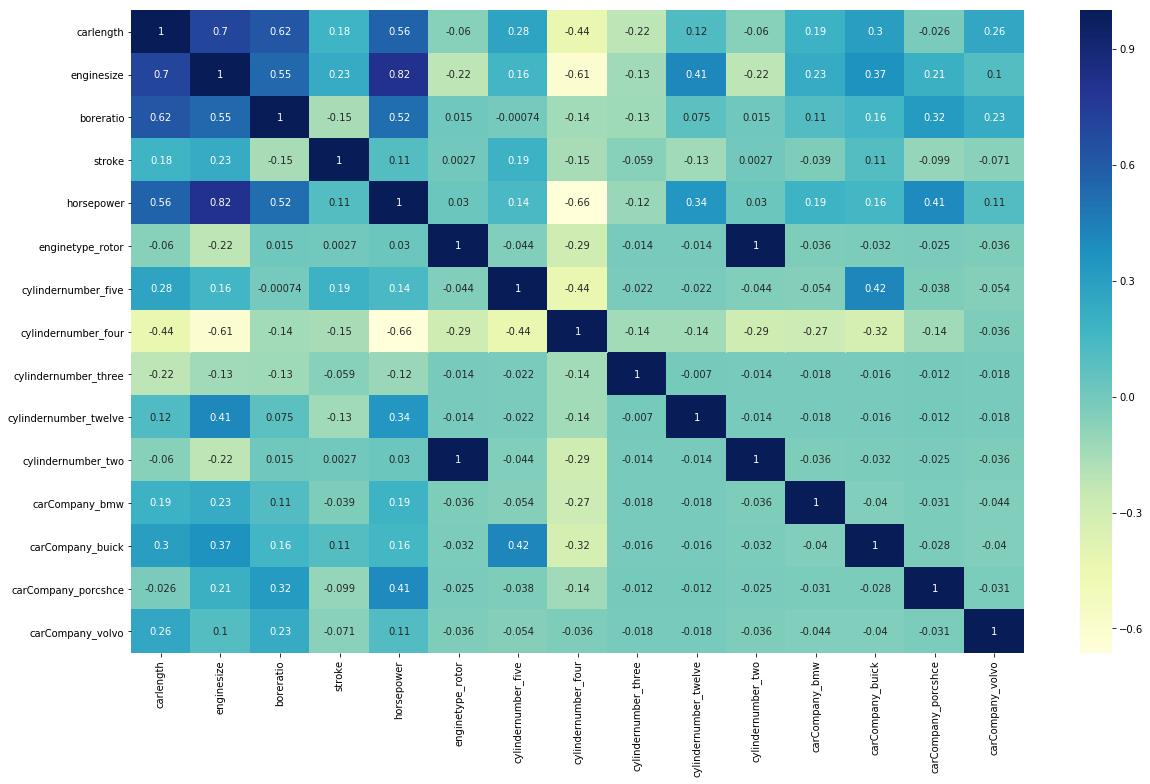

In [1696]:
plotHeatMap(X_train[supported_vars])

As we can see all variable have p-value < 0.05. So we look for correlation using VIF, We find that many variables have VIF greater than 2.
We generally want a VIF that is less than 2. So there are clearly some variables we need to drop.

### Dropping the variable and updating the model

As we can see from heat map the cylindernumber_two and enginetype_rotor are highly corelated, the corelation is 1 and also the Vif value is pretty high for enginetype_rotor. It is infinity lets drop it.

In [1697]:
# Dropping highly correlated variables and insignificant variables
supported_vars= getSupporedVars(supported_vars, drop_vars=['enginetype_rotor'])
buildModelAndGetSummary(supported_vars)
getVIF_Details(supported_vars)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     120.4
Date:                Sun, 31 May 2020   Prob (F-statistic):           1.76e-66
Time:                        22:49:36   Log-Likelihood:                 206.50
No. Observations:                 143   AIC:                            -383.0
Df Residuals:                     128   BIC:                            -338.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.25

,Features,VIF
1,enginesize,81.14
2,boreratio,40.88
3,stroke,36.22
6,cylindernumber_four,26.70
0,carlength,26.47
4,horsepower,14.69
9,cylindernumber_two,4.20
8,cylindernumber_twelve,3.11
5,cylindernumber_five,2.87
11,carCompany_buick,2.01


Dropping highly correlated variables and insignificant variables, as we see 'boreratio' has high VIF

In [1698]:
supported_vars= getSupporedVars(supported_vars, drop_vars=['boreratio'])
buildModelAndGetSummary(supported_vars)
getVIF_Details(supported_vars)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     99.29
Date:                Sun, 31 May 2020   Prob (F-statistic):           1.59e-60
Time:                        22:49:36   Log-Likelihood:                 188.44
No. Observations:                 143   AIC:                            -348.9
Df Residuals:                     129   BIC:                            -307.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.13

,Features,VIF
1,enginesize,43.12
0,carlength,25.39
2,stroke,16.79
3,horsepower,14.69
5,cylindernumber_four,8.73
4,cylindernumber_five,2.26
8,cylindernumber_two,2.11
7,cylindernumber_twelve,2.01
10,carCompany_buick,1.87
11,carCompany_porcshce,1.60


As we can see variable 'strok' is having high VIF as well as p-value greater than 0.05 

In [1699]:
# Dropping highly correlated variables and insignificant variables
supported_vars= getSupporedVars(supported_vars, drop_vars=['stroke'])
buildModelAndGetSummary(supported_vars)
getVIF_Details(supported_vars)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     107.9
Date:                Sun, 31 May 2020   Prob (F-statistic):           1.91e-61
Time:                        22:49:37   Log-Likelihood:                 188.16
No. Observations:                 143   AIC:                            -350.3
Df Residuals:                     130   BIC:                            -311.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.14

,Features,VIF
1,enginesize,28.95
0,carlength,24.13
2,horsepower,14.61
4,cylindernumber_four,4.00
3,cylindernumber_five,1.75
9,carCompany_buick,1.70
7,cylindernumber_two,1.54
10,carCompany_porcshce,1.51
6,cylindernumber_twelve,1.50
8,carCompany_bmw,1.25


As we can see variable 'cylindernumber_four' is having high VIF as well as p-value greater than 0.05 

In [1700]:
# Dropping highly correlated variables and insignificant variables
supported_vars= getSupporedVars(supported_vars, drop_vars=['cylindernumber_four'])
buildModelAndGetSummary(supported_vars)
getVIF_Details(supported_vars)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     118.2
Date:                Sun, 31 May 2020   Prob (F-statistic):           2.19e-62
Time:                        22:49:37   Log-Likelihood:                 187.89
No. Observations:                 143   AIC:                            -351.8
Df Residuals:                     131   BIC:                            -316.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.12

,Features,VIF
1,enginesize,26.92
2,horsepower,14.38
0,carlength,11.37
8,carCompany_buick,1.69
5,cylindernumber_twelve,1.49
9,carCompany_porcshce,1.49
3,cylindernumber_five,1.43
6,cylindernumber_two,1.40
7,carCompany_bmw,1.16
10,carCompany_volvo,1.13


As we can see variable 'cylindernumber_twelve' is having p-value greater than 0.05 

In [1701]:
# Dropping highly correlated variables and insignificant variables
supported_vars= getSupporedVars(supported_vars, drop_vars=['cylindernumber_twelve'])
buildModelAndGetSummary(supported_vars)
getVIF_Details(supported_vars)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     130.5
Date:                Sun, 31 May 2020   Prob (F-statistic):           2.33e-63
Time:                        22:49:37   Log-Likelihood:                 187.64
No. Observations:                 143   AIC:                            -353.3
Df Residuals:                     132   BIC:                            -320.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1190 

,Features,VIF
1,enginesize,22.20
2,horsepower,14.35
0,carlength,8.79
7,carCompany_buick,1.59
3,cylindernumber_five,1.43
8,carCompany_porcshce,1.42
5,cylindernumber_two,1.37
6,carCompany_bmw,1.13
9,carCompany_volvo,1.13
4,cylindernumber_three,1.00


Dropping highly correlated variables and insignificant variables, as we see 'horsepower' has high VIF

In [1702]:
# Dropping highly correlated variables and insignificant variables
supported_vars = getSupporedVars(supported_vars, drop_vars=['horsepower'])
buildModelAndGetSummary(supported_vars)
getVIF_Details(supported_vars)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     137.7
Date:                Sun, 31 May 2020   Prob (F-statistic):           6.31e-63
Time:                        22:49:37   Log-Likelihood:                 183.84
No. Observations:                 143   AIC:                            -347.7
Df Residuals:                     133   BIC:                            -318.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1200 

,Features,VIF
1,enginesize,9.12
0,carlength,8.77
6,carCompany_buick,1.43
2,cylindernumber_five,1.37
7,carCompany_porcshce,1.15
5,carCompany_bmw,1.13
8,carCompany_volvo,1.12
4,cylindernumber_two,1.11
3,cylindernumber_three,1.00


As we can see variable 'cylindernumber_three' is having p-value greater than 0.05 

In [1703]:
# Dropping highly correlated variables and insignificant variables
supported_vars = getsupportedVars(supported_vars, drop_vars=['cylindernumber_three'])
buildModelAndGetSummary(supported_vars)
getVIF_Details(supported_vars)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     152.5
Date:                Sun, 31 May 2020   Prob (F-statistic):           2.01e-63
Time:                        22:49:37   Log-Likelihood:                 182.32
No. Observations:                 143   AIC:                            -346.6
Df Residuals:                     134   BIC:                            -320.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1126    

,Features,VIF
1,enginesize,9.12
0,carlength,8.77
5,carCompany_buick,1.43
2,cylindernumber_five,1.37
6,carCompany_porcshce,1.15
4,carCompany_bmw,1.13
7,carCompany_volvo,1.12
3,cylindernumber_two,1.11


Dropping highly correlated variables and insignificant variables, as we see 'carlength' has high VIF

In [1704]:
# Dropping highly correlated variables and insignificant variables
supported_vars = getSupporedVars(supported_vars, drop_vars=['carlength'])
lr_model = buildModelAndGetSummary(supported_vars)
getVIF_Details(supported_vars)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     159.8
Date:                Sun, 31 May 2020   Prob (F-statistic):           4.23e-62
Time:                        22:49:37   Log-Likelihood:                 176.30
No. Observations:                 143   AIC:                            -336.6
Df Residuals:                     135   BIC:                            -312.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0690    

,Features,VIF
0,enginesize,1.51
4,carCompany_buick,1.36
1,cylindernumber_five,1.30
3,carCompany_bmw,1.13
5,carCompany_porcshce,1.08
6,carCompany_volvo,1.08
2,cylindernumber_two,1.00


__Since the R square and Adjusted R square value in Final Model is almost same which is 0.892 and 0.887 respectively with low p value (<0.05) and low VIF value (<5), we are selecting this as our Final Model.__

Now that the features have been selected and the model is built, let's do the residual analysis and make the final predictions.

## Step 4: Residual analysis

Before making the predictions, you need to be certain that the model is reliable. To that end, you need to first perform a residual analysis of the error terms and then move on to making the predictions on the test set; and finally, evaluate the model based on the predictions.

In [1705]:
X_train_new = X_train[supported_vars] 
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train, X_train_lm).fit()
y_train_pred = lm.predict(X_train_lm)
res = y_train - y_train_pred

Text(0.5, 0, 'Errors')

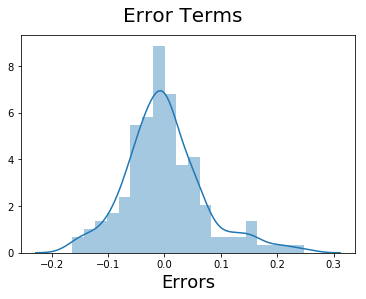

In [1706]:
# Plot the error term of histogram
fig = plt.figure()
sns.distplot(res, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)

## Step 5: Predictions and evaluation on test set

Applying the scaling on the test sets

In [1707]:
df_test[numerical_var] = scaler.transform(df_test[numerical_var])
df_test.head()

,symboling,carlength,carheight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,price,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_rwd,enginelocation_rear,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spfi,carCompany_audi,carCompany_bmw,carCompany_buick,carCompany_chevrolet,carCompany_dodge,carCompany_honda,carCompany_isuzu,carCompany_jaguar,carCompany_mazda,carCompany_mercury,carCompany_mitsubishi,carCompany_nissan,carCompany_peugeot,carCompany_plymouth,carCompany_porcshce,carCompany_renault,carCompany_saab,carCompany_subaru,carCompany_toyota,carCompany_toyouta,carCompany_volkswagen,carCompany_volvo
160,0.4,0.409756,0.460177,0.139623,0.404762,0.424242,0.12500,0.091667,0.265306,0.694444,0.072382,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
186,0.8,0.497561,0.699115,0.181132,0.404762,0.611111,0.12500,0.154167,0.448980,0.388889,0.093295,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
59,0.6,0.596748,0.522124,0.230189,0.563492,0.606061,0.10000,0.150000,0.265306,0.361111,0.102964,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
165,0.6,0.448780,0.424779,0.139623,0.444444,0.449495,0.15000,0.266667,1.000000,0.361111,0.115479,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
140,0.8,0.263415,0.699115,0.177358,0.746032,0.227273,0.10625,0.104167,0.102041,0.361111,0.068652,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


__Dividing into X_test and y_test__

In [1708]:
y_tset = df_test.pop('price')
X_test = df_test

In [1709]:
# Now, Let's ues our model to make predictions.
# Creating X_test_new dataframe by droping variable from X_test
X_test_new = X_test[supported_vars]

# Adding a constant variable
X_test_new = sm.add_constant(X_test_new)

In [1715]:
# Making predictions
y_test_pred = lm.predict(X_test_new)

Text(0, 0.5, 'Car Price')

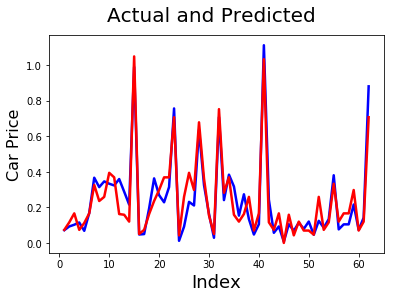

In [1711]:
c = [i for i in range(1,y_tset.size+1,1)] # generating index 
# Actual versus predict value
fig = plt.figure()
plt.plot(c, y_tset, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,y_test_pred, color="red",  linewidth=2.5, linestyle="-") 
fig.suptitle('Actual and Predicted', fontsize=20)             
plt.xlabel('Index', fontsize=18)                               
plt.ylabel('Car Price', fontsize=16)     

Text(0, 0.5, 'y_pred')

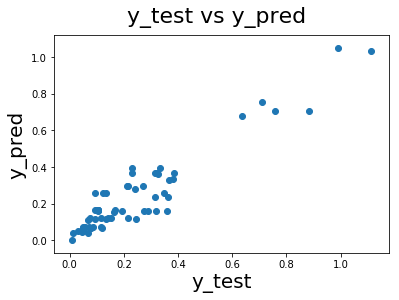

In [1712]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_tset,y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 22)
plt.xlabel('y_test', fontsize = 20)
plt.ylabel('y_pred', fontsize = 20)

In [1713]:
r2_score(y_tset,y_test_pred)

0.8873648100263454

In [1714]:
np.sqrt(mean_squared_error(y_tset,y_test_pred))

0.07758963906557098

## Summary
We can see that the equation of our best fitted line is:

$ price = 1.0245  \times  enginesize + 0.1125  \times  cylindernumber_five + 0.2428 \times cylindernumber_two + 0.2500 \times  carCompany_bmw + 0.1640 \times    carCompany_buick + 0.2625 \times    carCompany_porcshce + 0.1292 \times    carCompany_volvo$

## Conclusion

The R square and Adjusted R square value in Final Model is almost same which is 0.892 and 0.887 respectively which indicates that none of the parameters in final model are reduntant.

Error term is also normally distributed.

The RMSE value is 0.07758963906557098

As we can see that the model seems to be stable, The variables that can affect price are:

- enginesize
- cylindernumber_five
- cylindernumber_two
- carCompany_bmw
- carCompany_buick
- carCompany_porcshce
- carCompany_volvo